# Uber Supply-Demand Gap Assignment

In [1]:
# Import the numpy and pandas packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read the csv file using 'read_csv'
uber_data = pd.read_csv('/kaggle/input/uberdata/Uber Request Data.csv')

In [3]:
# Observing actual data in dataframe
uber_data.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11-07-2016 11:51,11-07-2016 13:00
1,867,Airport,1.0,Trip Completed,11-07-2016 17:57,11-07-2016 18:47
2,1807,City,1.0,Trip Completed,12-07-2016 09:17,12-07-2016 09:58
3,2532,Airport,1.0,Trip Completed,12-07-2016 21:08,12-07-2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33,13-07-2016 09:25


In [4]:
# Check the number of rows and columns in the dataframe
uber_data.shape

(6745, 6)

In [5]:
# Check the column-wise info of the dataframe
uber_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Request id         6745 non-null   int64  
 1   Pickup point       6745 non-null   object 
 2   Driver id          4095 non-null   float64
 3   Status             6745 non-null   object 
 4   Request timestamp  6745 non-null   object 
 5   Drop timestamp     2831 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 316.3+ KB


** Inference 3:** 'Driver id' fields and 'Drop timestamp' have many 'NaN' values

### Summary of Inspecting the dataframe
* 'Driver id' fields have decimal values however, it should be integer values
* 'Request timestamp' and 'Drop timestamp' fields have dates in different formats however, it should be in uniform format for analysis. Eg. '15-07-2016 10:00:43' vs. '11/7/2016 13:08'
* 'Driver id' fields and 'Drop timestamp' have many 'NaN' values

## Data Cleaning

### Ignoring 'Driver id' field since our analysis is focussed on aggregation of all bookings and not individual bookings

In [6]:
uber_data = uber_data.drop(['Driver id'], axis = 1)

### Converting 'Request timestamp' and 'Drop timestamp' fields to uniform format

In [8]:
uber_data[pd.isna(uber_data['Drop timestamp'])==1]['Status'].value_counts()

Status
No Cars Available    2650
Cancelled            1264
Name: count, dtype: int64

In [10]:
# Imputing the null drop timestamp to request time stamp because drop timestamp is null due to service
# not delivered to the customer
uber_data.loc[pd.isnull(uber_data['Drop timestamp']), ['Drop timestamp']] = uber_data['Request timestamp']

In [11]:
uber_data['Request timestamp'] = uber_data['Request timestamp'].str.replace('/', '-')
uber_data['Drop timestamp'] = uber_data['Drop timestamp'].str.replace('/', '-')

# Convert the two fields into timestamp class
uber_data['Request timestamp'] = pd.to_datetime(uber_data['Request timestamp'], format='%d-%m-%Y %H:%M')
uber_data['Drop timestamp'] = pd.to_datetime(uber_data['Drop timestamp'], format='%d-%m-%Y %H:%M')

In [12]:
# Get the column-wise Null count using 'is.null()' alongwith the 'sum()' function
uber_data.isnull().sum()

Request id           0
Pickup point         0
Status               0
Request timestamp    0
Drop timestamp       0
dtype: int64

In [13]:
uber_data['Pickup point'].value_counts(normalize = True)*100

Pickup point
City       51.99407
Airport    48.00593
Name: proportion, dtype: float64

In [14]:
uber_data['Status'].value_counts(normalize = True)*100

Status
Trip Completed       41.971831
No Cars Available    39.288362
Cancelled            18.739807
Name: proportion, dtype: float64

# Trip completed
1. Pickup wise completed trip %
2. Hour stamp wise completed trip% for

In [12]:
uber_trip_completed = uber_data[uber_data['Status'] == 'Trip Completed']
uber_trip_completed['Pickup point'].value_counts(normalize = True)*100

Pickup point
City       53.126104
Airport    46.873896
Name: proportion, dtype: float64

In [13]:
uber_no_cars = uber_data[uber_data['Status'] == 'No Cars Available']
uber_no_cars['Pickup point'].value_counts(normalize = True)*100

Pickup point
Airport    64.641509
City       35.358491
Name: proportion, dtype: float64

In [14]:
uber_cancel = uber_data[uber_data['Status'] == 'Cancelled']
uber_cancel['Pickup point'].value_counts(normalize = True)*100

Pickup point
City       84.335443
Airport    15.664557
Name: proportion, dtype: float64

### Making a derived column, 'Duration'

In [15]:
uber_data['Duration'] = uber_data['Drop timestamp']-uber_data['Request timestamp']

uber_data['Duration'] = round(uber_data['Duration'].dt.total_seconds()/60,1)

In [16]:
# Deriving Relevant metrics from the dataset
uber_data['Request hour'] = uber_data['Request timestamp'].dt.hour
uber_data['Request day'] = uber_data['Request timestamp'].dt.day_name()

# Creating a categorical attribute service status
uber_data['service status'] = ''
uber_data.loc[uber_data['Status'] == 'Trip Completed', 'service status'] = 'Service Provided'
uber_data.loc[uber_data['Status'].isin(['Cancelled', 'No Cars Available']), 'service status'] = 'Service Denied'


In [17]:
uber_data['Time slot'] = pd.Series(np.select([
    (uber_data.iloc[:, 7] >= 5) & (uber_data.iloc[:, 7] <= 9),
    (uber_data.iloc[:, 7] >= 10) & (uber_data.iloc[:, 7] <= 13),
    (uber_data.iloc[:, 7] >= 14) & (uber_data.iloc[:, 7] < 17),
    (uber_data.iloc[:, 7] >= 17) & (uber_data.iloc[:, 7] <= 22),
    (uber_data.iloc[:, 7] > 22) | (uber_data.iloc[:, 7] < 5)
], ['5am - 9am', '10am - 1pm', '2pm - 4pm', '5pm - 10pm', '11pm - 4am']))


5am -  9am = Morning Peak hour\
10am - 1pm = Late Noon\
2pm -  4pm = Early evening\
6pm - 10pm = Late Evening\
11pm - 5am = Night

In [18]:
uber_data['Time slot'].value_counts()

Time slot
5pm - 10pm    2646
5am - 9am     2103
11pm - 4am     772
10am - 1pm     758
2pm - 4pm      466
Name: count, dtype: int64

In [19]:
percentage_share = pd.DataFrame(uber_data['Status'].value_counts(normalize=True) * 100)

# Reset index to move 'Status' to a column
percentage_share.reset_index(inplace=True)

# Rename columns
percentage_share.columns = ['Status', '%']
percentage_share

,Status,%
0,Trip Completed,41.971831
1,No Cars Available,39.288362
2,Cancelled,18.739807


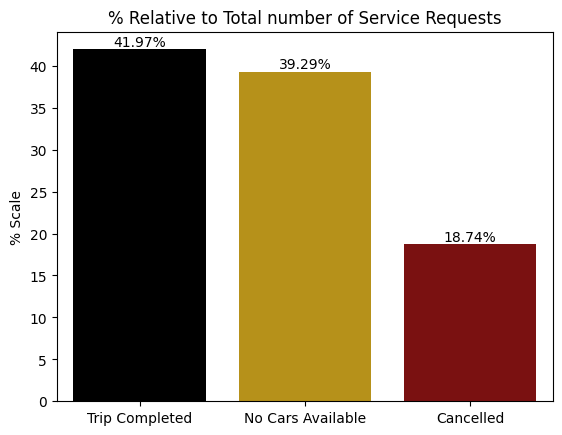

In [20]:
# Plot
custom_palette = [(0, 0, 0), (208/255, 158/255, 0), (139/255, 0/255, 0/255)]
overall_servicerate = sns.barplot(data=percentage_share,
                                  x='Status',  # Specify 'Status' as x
                                  y='%',  # Specify 'Proportion (%)' as y
                                 palette = custom_palette 
                                 )  # Set palette

# Add percentage labels on each bar
for i, val in enumerate(percentage_share['%']):
    plt.text(i, val, f'{val:.2f}%', ha='center', va='bottom', fontsize=10)

# Set plot title and labels
plt.title('% Relative to Total number of Service Requests')
plt.xlabel('')
plt.ylabel('% Scale')

plt.show()


In [21]:
percentage_share = pd.DataFrame(uber_data['Pickup point'].value_counts(normalize=True) * 100)

# Reset index to move 'Status' to a column
percentage_share.reset_index(inplace=True)

# Rename columns
percentage_share.columns = ['Pickup Point', '%']
percentage_share

,Pickup Point,%
0,City,51.99407
1,Airport,48.00593


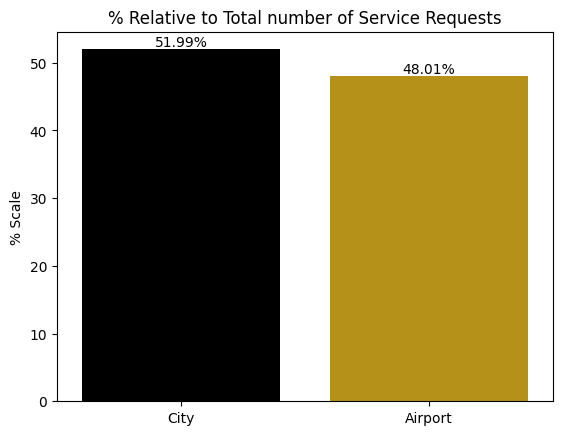

In [22]:
# Plot
# bar_width = 0.5
custom_palette = [(0, 0, 0), (208/255, 158/255, 0), (139/255, 0/255, 0/255)]
overall_servicerate = sns.barplot(data=percentage_share,
                                  x='Pickup Point',  # Specify 'Status' as x
                                  y='%',  # Specify 'Proportion (%)' as y
                                 palette = custom_palette 
                                 )  # Set palette

# Add percentage labels on each bar
for i, val in enumerate(percentage_share['%']):
    plt.text(i, val, f'{val:.2f}%', ha='center', va='bottom', fontsize=10)

# for bar in overall_servicerate.patches:
#     bar.set_width(bar_width)
    
# Set plot title and labels
plt.title('% Relative to Total number of Service Requests')
plt.xlabel('')
plt.ylabel('% Scale')

plt.show()


In [23]:
uber_data['service status'].value_counts()

service status
Service Denied      3914
Service Provided    2831
Name: count, dtype: int64

In [ ]:
uber_data2 = uber_data[uber_data['service status'] == 'Service Denied']

percentage_share = pd.DataFrame(uber_data2['Pickup point'].value_counts(normalize=True) * 100)

# Reset index to move 'Status' to a column
percentage_share.reset_index(inplace=True)

# Rename columns
percentage_share.columns = ['Pickup Point', '%']
percentage_share

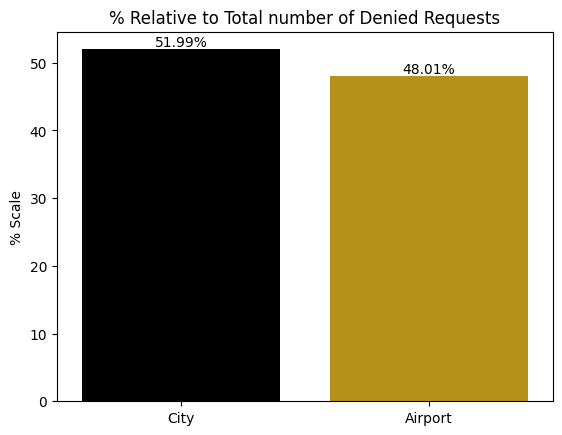

In [25]:
# Plot
# bar_width = 0.5
custom_palette = [(0, 0, 0), (208/255, 158/255, 0), (139/255, 0/255, 0/255)]
overall_servicerate = sns.barplot(data=percentage_share,
                                  x='Pickup Point',  # Specify 'Status' as x
                                  y='%',  # Specify 'Proportion (%)' as y
                                 palette = custom_palette 
                                 )  # Set palette

# Add percentage labels on each bar
for i, val in enumerate(percentage_share['%']):
    plt.text(i, val, f'{val:.2f}%', ha='center', va='bottom', fontsize=10)

# for bar in overall_servicerate.patches:
#     bar.set_width(bar_width)
    
# Set plot title and labels
plt.title('% Relative to Total number of Denied Requests')
plt.xlabel('')
plt.ylabel('% Scale')

plt.show()


In [26]:
uber_data2 = uber_data[uber_data['Pickup point'] == 'City']

percentage_share = pd.DataFrame(uber_data2['Status'].value_counts(normalize=True) * 100)

# Reset index to move 'Status' to a column
percentage_share.reset_index(inplace=True)

# Rename columns
percentage_share.columns = ['Pickup Point', '%']
percentage_share

,Pickup Point,%
0,Trip Completed,42.885657
1,Cancelled,30.396350
2,No Cars Available,26.717993


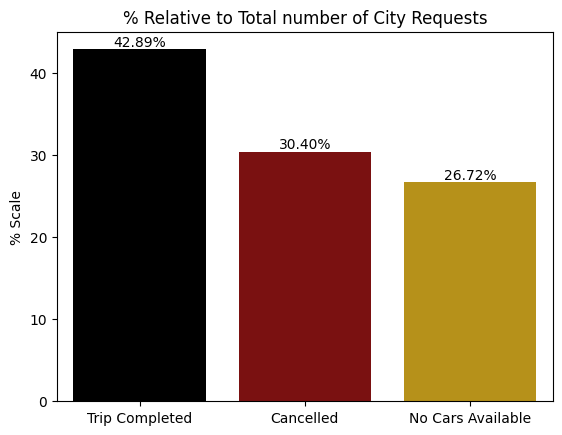

In [27]:
# Plot
# bar_width = 0.5
custom_palette = [(0, 0, 0), (139/255, 0/255, 0/255),(208/255, 158/255, 0)]
overall_servicerate = sns.barplot(data=percentage_share,
                                  x='Pickup Point',  # Specify 'Status' as x
                                  y='%',  # Specify 'Proportion (%)' as y
                                 palette = custom_palette 
                                 )  # Set palette

# Add percentage labels on each bar
for i, val in enumerate(percentage_share['%']):
    plt.text(i, val, f'{val:.2f}%', ha='center', va='bottom', fontsize=10)

# for bar in overall_servicerate.patches:
#     bar.set_width(bar_width)
    
# Set plot title and labels
plt.title('% Relative to Total number of City Requests')
plt.xlabel('')
plt.ylabel('% Scale')

plt.show()


In [28]:
uber_data2 = uber_data[uber_data['Pickup point'] == 'Airport']

percentage_share = pd.DataFrame(uber_data2['Status'].value_counts(normalize=True) * 100)

# Reset index to move 'Status' to a column
percentage_share.reset_index(inplace=True)

# Rename columns
percentage_share.columns = ['Pickup Point', '%']
percentage_share

,Pickup Point,%
0,No Cars Available,52.903027
1,Trip Completed,40.982088
2,Cancelled,6.114886


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


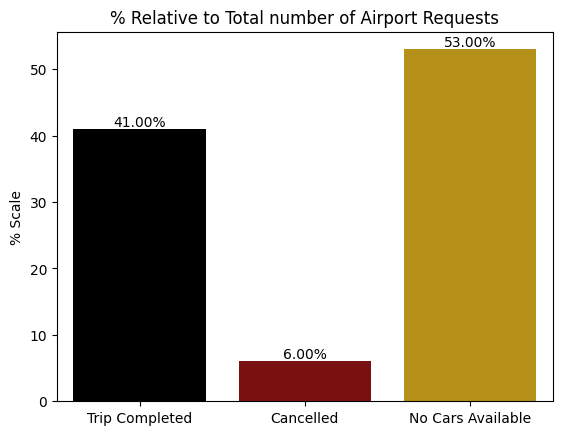

In [29]:
# Plot
# bar_width = 0.5
custom_palette = [ (0, 0, 0), (139/255, 0/255, 0/255),(208/255, 158/255, 0)]
overall_servicerate = sns.barplot(
#     data= [41,6,53],
                                  x=['Trip Completed','Cancelled','No Cars Available'] ,  # Specify 'Status' as x
                                  y=[41,6,53],  # Specify 'Proportion (%)' as y
                                 palette = custom_palette 
                                 )  # Set palette

# Add percentage labels on each bar
for i, val in enumerate([41,6,53]):
    plt.text(i, val, f'{val:.2f}%', ha='center', va='bottom', fontsize=10)

# for bar in overall_servicerate.patches:
#     bar.set_width(bar_width)
    
# Set plot title and labels
plt.title('% Relative to Total number of Airport Requests')
plt.xlabel('')
plt.ylabel('% Scale')

plt.show()


In [30]:
uber_data.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Duration,Request hour,Request day,service status,Time slot
0,619,Airport,1.0,Trip Completed,2016-07-11 11:51:00,2016-07-11 13:00:00,69.0,11,Monday,Service Provided,10am - 1pm
1,867,Airport,1.0,Trip Completed,2016-07-11 17:57:00,2016-07-11 18:47:00,50.0,17,Monday,Service Provided,5pm - 10pm
2,1807,City,1.0,Trip Completed,2016-07-12 09:17:00,2016-07-12 09:58:00,41.0,9,Tuesday,Service Provided,5am - 9am
3,2532,Airport,1.0,Trip Completed,2016-07-12 21:08:00,2016-07-12 22:03:00,55.0,21,Tuesday,Service Provided,5pm - 10pm
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:00,2016-07-13 09:25:00,52.0,8,Wednesday,Service Provided,5am - 9am


In [31]:
uber_data2 = uber_data[uber_data['Pickup point'] == 'City']
uber_data2['Time slot'].value_counts(normalize = True)*100

Time slot
5am - 9am     47.818648
5pm - 10pm    18.905047
10am - 1pm    13.316225
11pm - 4am    12.004562
2pm - 4pm      7.955518
Name: proportion, dtype: float64

In [32]:
uber_data2 = uber_data[uber_data['Pickup point'] != 'City']
uber_data2['Time slot'].value_counts(normalize = True)*100

Time slot
5pm - 10pm    61.241507
5am - 9am     13.156269
11pm - 4am    10.840025
10am - 1pm     8.987029
2pm - 4pm      5.775170
Name: proportion, dtype: float64

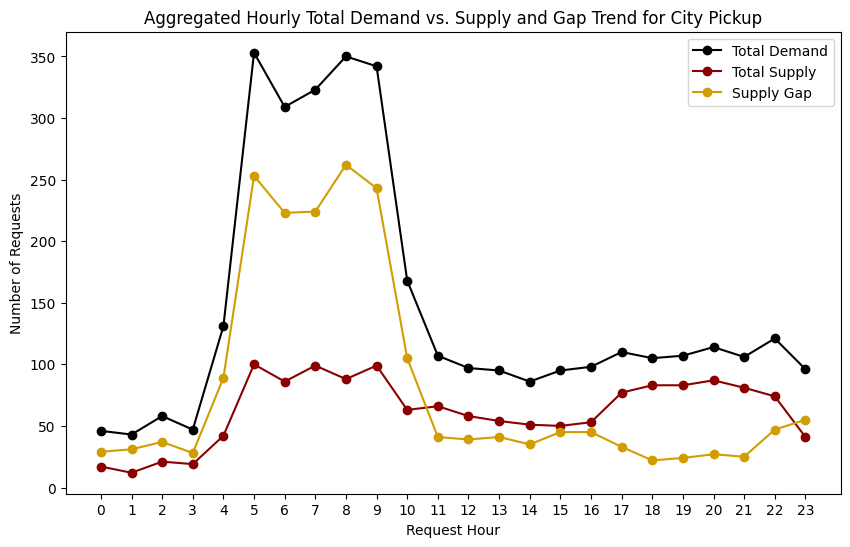

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
uber_data2 = uber_data[uber_data['Pickup point'] == 'City'] 
# Custom palette
custom_palette = [(0, 0, 0), (139/255, 0/255, 0/255), (208/255, 158/255, 0)]

# Grouping data by Request Hour to calculate total demand
hourly_demand = uber_data2.groupby('Request hour').size().reset_index(name='Total Demand')

# Filtering data for completed trips to calculate total supply
hourly_supply = uber_data2[uber_data2['Status'] == 'Trip Completed'].groupby('Request hour').size().reset_index(name='Total Supply')

# Merging demand and supply dataframes
hourly_analysis = pd.merge(hourly_demand, hourly_supply, on='Request hour', how='outer')

# Calculating Supply Gap
hourly_analysis['Supply Gap'] = hourly_analysis['Total Demand'] - hourly_analysis['Total Supply']

# Plotting Hourly Supply-Demand Gap Trend
plt.figure(figsize=(10, 6))

plt.plot(hourly_analysis['Request hour'], hourly_analysis['Total Demand'], marker='o', color=custom_palette[0], label='Total Demand')
plt.plot(hourly_analysis['Request hour'], hourly_analysis['Total Supply'], marker='o', color=custom_palette[1], label='Total Supply')
plt.plot(hourly_analysis['Request hour'], hourly_analysis['Supply Gap'], marker='o', color=custom_palette[2], label='Supply Gap')

plt.title('Aggregated Hourly Total Demand vs. Supply and Gap Trend for City Pickup')
plt.xlabel('Request Hour')
plt.ylabel('Number of Requests')
plt.xticks(hourly_analysis['Request hour'])
plt.legend()

plt.grid(False)
plt.show()


In [34]:
uber_data2 = uber_data[uber_data['Pickup point'] == 'City'] 


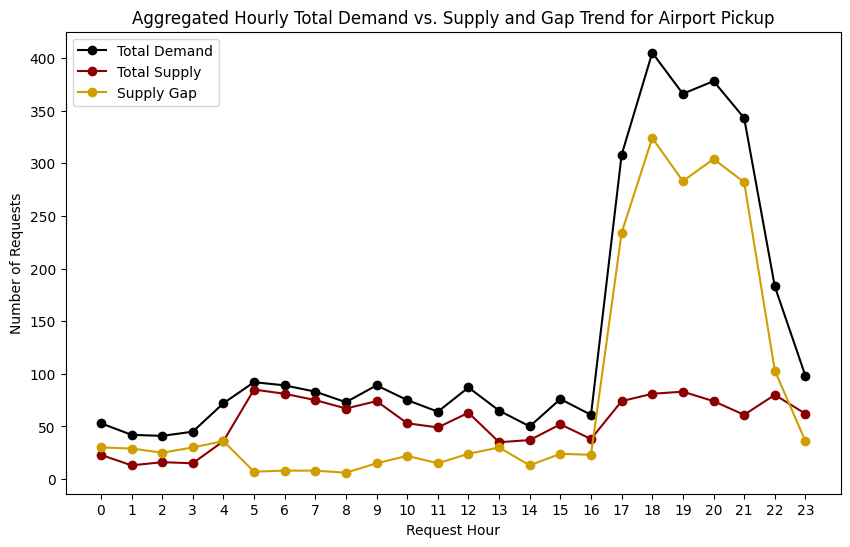

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
uber_data2 = uber_data[uber_data['Pickup point'] != 'City'] 
# Custom palette
custom_palette = [(0, 0, 0), (139/255, 0/255, 0/255), (208/255, 158/255, 0)]

# Grouping data by Request Hour to calculate total demand
hourly_demand = uber_data2.groupby('Request hour').size().reset_index(name='Total Demand')

# Filtering data for completed trips to calculate total supply
hourly_supply = uber_data2[uber_data2['Status'] == 'Trip Completed'].groupby('Request hour').size().reset_index(name='Total Supply')

# Merging demand and supply dataframes
hourly_analysis = pd.merge(hourly_demand, hourly_supply, on='Request hour', how='outer')

# Calculating Supply Gap
hourly_analysis['Supply Gap'] = hourly_analysis['Total Demand'] - hourly_analysis['Total Supply']

# Plotting Hourly Supply-Demand Gap Trend
plt.figure(figsize=(10, 6))

plt.plot(hourly_analysis['Request hour'], hourly_analysis['Total Demand'], marker='o', color=custom_palette[0], label='Total Demand')
plt.plot(hourly_analysis['Request hour'], hourly_analysis['Total Supply'], marker='o', color=custom_palette[1], label='Total Supply')
plt.plot(hourly_analysis['Request hour'], hourly_analysis['Supply Gap'], marker='o', color=custom_palette[2], label='Supply Gap')

plt.title('Aggregated Hourly Total Demand vs. Supply and Gap Trend for Airport Pickup')
plt.xlabel('Request Hour')
plt.ylabel('Number of Requests')
plt.xticks(hourly_analysis['Request hour'])
plt.legend()

plt.grid(0)
plt.show()


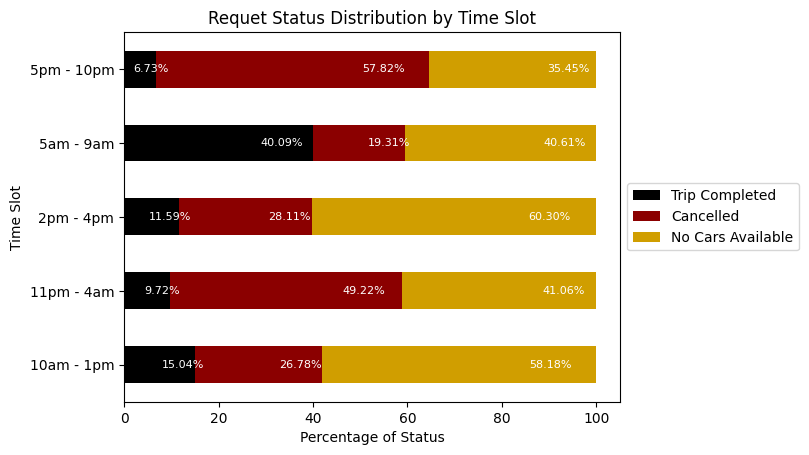

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom palette
custom_palette = [(0, 0, 0), (139/255, 0/255, 0/255), (208/255, 158/255, 0)]

# Calculate the percentage of each status within each time slot
status_percentage = uber_data.groupby('Time slot')['Status'].value_counts(normalize=True).mul(100).unstack()

# Plot horizontal stacked bar chart with custom palette
ax = status_percentage.plot(kind='barh', stacked=True, color=custom_palette)

# Add labels to each stack
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{width:.2f}%', (x + width/1.2, y + height/2), ha='center', va='center', fontsize=8,color = 'white')

# Set plot title and labels
plt.title('Requet Status Distribution by Time Slot')
plt.xlabel('Percentage of Status')
plt.ylabel('Time Slot')

# Move legend outside the chart area
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=['Trip Completed', 'Cancelled', 'No Cars Available'])

# Show plot
plt.show()


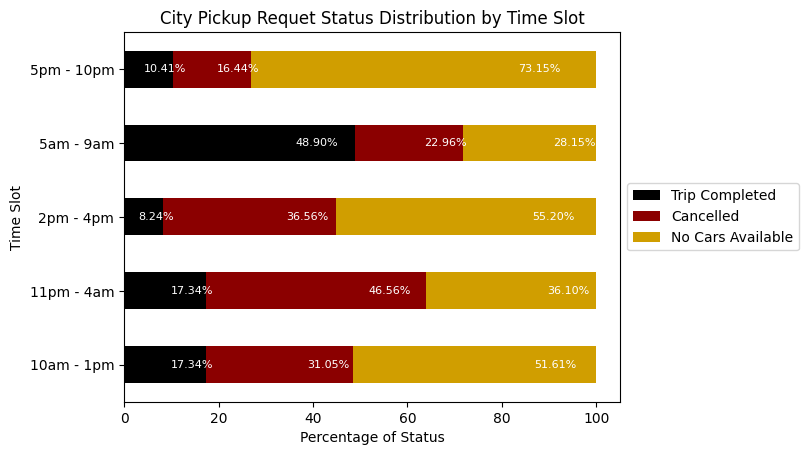

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

uber_data2 = uber_data[uber_data['Pickup point'] == 'City'] 
# Define custom palette
custom_palette = [(0, 0, 0), (139/255, 0/255, 0/255), (208/255, 158/255, 0)]

# Calculate the percentage of each status within each time slot
status_percentage = uber_data2.groupby('Time slot')['Status'].value_counts(normalize=True).mul(100).unstack()

# Plot horizontal stacked bar chart with custom palette
ax = status_percentage.plot(kind='barh', stacked=True, color=custom_palette)

# Add labels to each stack
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{width:.2f}%', (x + width/1.2, y + height/2), ha='center', va='center', fontsize=8,color = 'white')

# Set plot title and labels
plt.title('City Pickup Requet Status Distribution by Time Slot')
plt.xlabel('Percentage of Status')
plt.ylabel('Time Slot')

# Move legend outside the chart area
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=['Trip Completed', 'Cancelled', 'No Cars Available'])

# Show plot
plt.show()


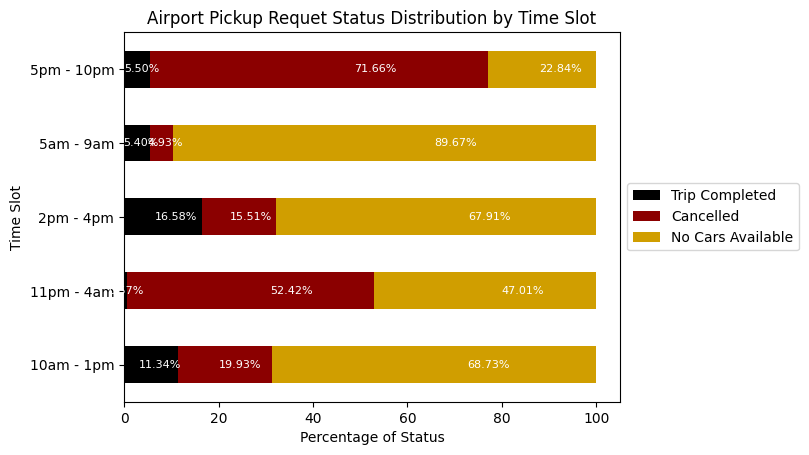

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

uber_data2 = uber_data[uber_data['Pickup point'] == 'Airport'] 
# Define custom palette
custom_palette = [(0, 0, 0), (139/255, 0/255, 0/255), (208/255, 158/255, 0)]

# Calculate the percentage of each status within each time slot
status_percentage = uber_data2.groupby('Time slot')['Status'].value_counts(normalize=True).mul(100).unstack()

# Plot horizontal stacked bar chart with custom palette
ax = status_percentage.plot(kind='barh', stacked=True, color=custom_palette)

# Add labels to each stack
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{width:.2f}%', (x + width/1.5, y + height/2), ha='center', va='center', fontsize=8,color = 'white')

# Set plot title and labels
plt.title('Airport Pickup Requet Status Distribution by Time Slot')
plt.xlabel('Percentage of Status')
plt.ylabel('Time Slot')

# Move legend outside the chart area
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=['Trip Completed', 'Cancelled', 'No Cars Available'])

# Show plot
plt.show()


In [39]:
uber_data2 = uber_data[uber_data['Pickup point'] != 'Airport']
status_counts = uber_data2.groupby('Time slot')['Status'].value_counts().unstack()
status_counts

Status,Cancelled,No Cars Available,Trip Completed
Time slot,,,
10am - 1pm,81,145,241
11pm - 4am,73,196,152
2pm - 4pm,23,102,154
5am - 9am,820,385,472
5pm - 10pm,69,109,485


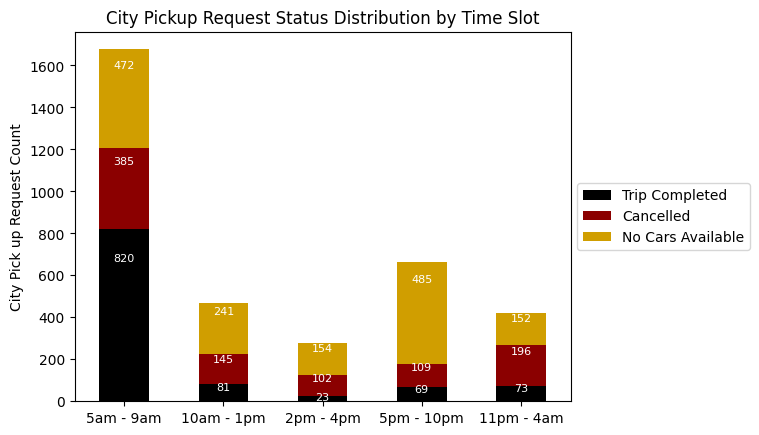

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom palette
custom_palette = [(0, 0, 0), (139/255, 0/255, 0/255), (208/255, 158/255, 0)]

# Sort the bars in the specified order
order = ['5am - 9am', '10am - 1pm', '2pm - 4pm', '5pm - 10pm', '11pm - 4am']
status_counts_sorted = status_counts.reindex(order)

# Plot stacked bar chart with custom palette
ax = status_counts_sorted.plot(kind='bar', stacked=True, color=custom_palette)

# Add labels to each stack
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{int(height)}', (x + width/2, y + height/1.2), ha='center', va='center', fontsize=8, color='white')

# Set plot title and labels
plt.title('City Pickup Request Status Distribution by Time Slot')
plt.xlabel('')
plt.ylabel('City Pick up Request Count')

# Rotate x-axis labels horizontally
plt.xticks(rotation=0)

# Move legend outside the chart area
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=['Trip Completed', 'Cancelled', 'No Cars Available'])

# Show plot
plt.show()

In [41]:
uber_data2 = uber_data[uber_data['Pickup point'] == 'Airport']
status_counts = uber_data2.groupby('Time slot')['Status'].value_counts().unstack()
status_counts

Status,Cancelled,No Cars Available,Trip Completed
Time slot,,,
10am - 1pm,33,58,200
11pm - 4am,2,184,165
2pm - 4pm,31,29,127
5am - 9am,23,21,382
5pm - 10pm,109,1421,453


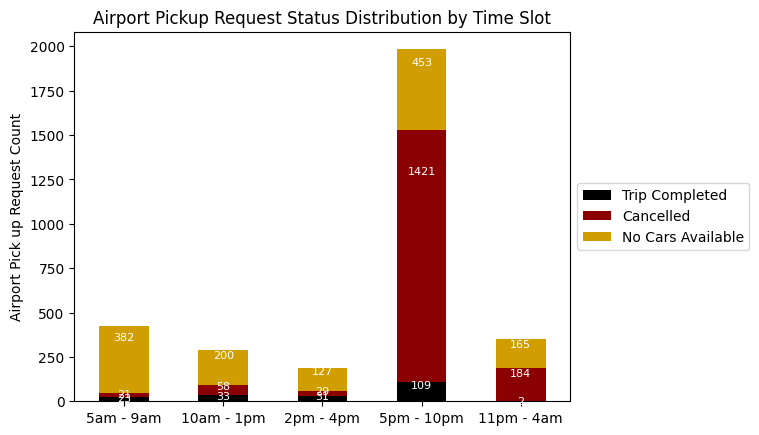

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom palette
custom_palette = [(0, 0, 0), (139/255, 0/255, 0/255), (208/255, 158/255, 0)]

# Sort the bars in the specified order
order = ['5am - 9am', '10am - 1pm', '2pm - 4pm', '5pm - 10pm', '11pm - 4am']
status_counts_sorted = status_counts.reindex(order)

# Plot stacked bar chart with custom palette
ax = status_counts_sorted.plot(kind='bar', stacked=True, color=custom_palette)

# Add labels to each stack
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{int(height)}', (x + width/2, y + height/1.2), ha='center', va='center', fontsize=8, color='white')

# Set plot title and labels
plt.title('Airport Pickup Request Status Distribution by Time Slot')
plt.xlabel('')
plt.ylabel('Airport Pick up Request Count')

# Rotate x-axis labels horizontally
plt.xticks(rotation=0)

# Move legend outside the chart area
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=['Trip Completed', 'Cancelled', 'No Cars Available'])

# Show plot
plt.show()

In [43]:
uber_data2 = uber_data[uber_data['Pickup point'] != 'Airport']
status_counts = uber_data2.groupby('Request day')['Status'].value_counts().unstack()
status_counts

Status,Cancelled,No Cars Available,Trip Completed
Request day,,,
Friday,209,250,293
Monday,220,166,320
Thursday,220,193,339
Tuesday,195,155,273
Wednesday,222,173,279


In [44]:
uber_data2['Request day'].value_counts()

Request day
Friday       752
Thursday     752
Monday       706
Wednesday    674
Tuesday      623
Name: count, dtype: int64

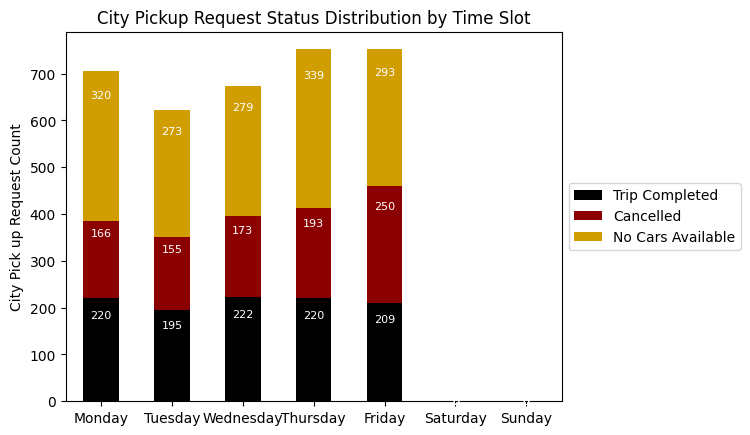

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom palette
custom_palette = [(0, 0, 0), (139/255, 0/255, 0/255), (208/255, 158/255, 0)]

# Sort the bars in the specified order
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday']
status_counts_sorted = status_counts.reindex(order)

# Plot stacked bar chart with custom palette
ax = status_counts_sorted.plot(kind='bar', stacked=True, color=custom_palette)

# Add labels to each stack
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{int(height)}', (x + width/2, y + height/1.2), ha='center', va='center', fontsize=8, color='white')

# Set plot title and labels
plt.title('City Pickup Request Status Distribution by Time Slot')
plt.xlabel('')
plt.ylabel('City Pick up Request Count')

# Rotate x-axis labels horizontally
plt.xticks(rotation=0)

# Move legend outside the chart area
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=['Trip Completed', 'Cancelled', 'No Cars Available'])

# Show plot
plt.show()

In [46]:
uber_data2 = uber_data[uber_data['Pickup point'] == 'Airport']
status_counts = uber_data2.groupby('Request day')['Status'].value_counts().unstack()
status_counts

Status,Cancelled,No Cars Available,Trip Completed
Request day,,,
Friday,31,330,268
Monday,42,338,281
Thursday,32,378,191
Tuesday,45,350,289
Wednesday,48,317,298


### Making a derived column, 'Slot'

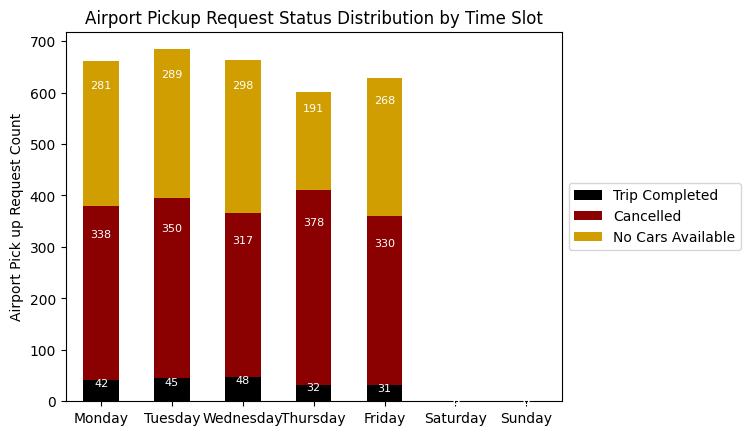

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom palette
custom_palette = [(0, 0, 0), (139/255, 0/255, 0/255), (208/255, 158/255, 0)]

# Sort the bars in the specified order
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday']
status_counts_sorted = status_counts.reindex(order)

# Plot stacked bar chart with custom palette
ax = status_counts_sorted.plot(kind='bar', stacked=True, color=custom_palette)

# Add labels to each stack
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{int(height)}', (x + width/2, y + height/1.2), ha='center', va='center', fontsize=8, color='white')

# Set plot title and labels
plt.title('Airport Pickup Request Status Distribution by Time Slot')
plt.xlabel('')
plt.ylabel('Airport Pick up Request Count')

# Rotate x-axis labels horizontally
plt.xticks(rotation=0)

# Move legend outside the chart area
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=['Trip Completed', 'Cancelled', 'No Cars Available'])

# Show plot
plt.show()

In [48]:
status_counts = uber_data.groupby('Time slot')['Status'].value_counts().unstack()
status_counts

Status,Cancelled,No Cars Available,Trip Completed
Time slot,,,
10am - 1pm,114,203,441
11pm - 4am,75,380,317
2pm - 4pm,54,131,281
5am - 9am,843,406,854
5pm - 10pm,178,1530,938


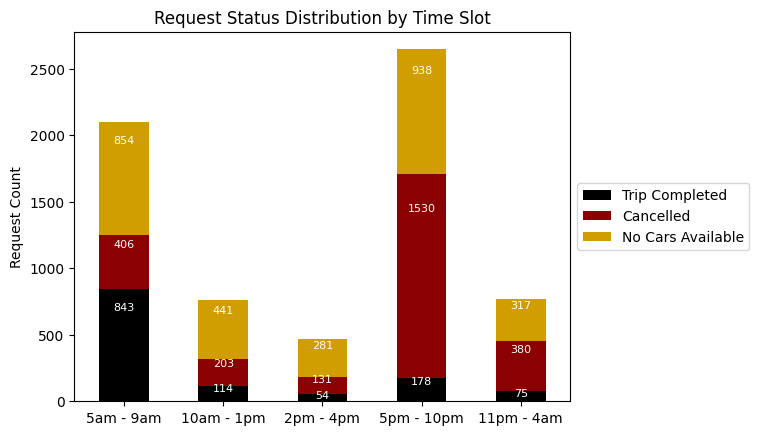

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom palette
custom_palette = [(0, 0, 0), (139/255, 0/255, 0/255), (208/255, 158/255, 0)]

# Sort the bars in the specified order
order = ['5am - 9am', '10am - 1pm', '2pm - 4pm', '5pm - 10pm', '11pm - 4am']
status_counts_sorted = status_counts.reindex(order)

# Plot stacked bar chart with custom palette
ax = status_counts_sorted.plot(kind='bar', stacked=True, color=custom_palette)

# Add labels to each stack
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{int(height)}', (x + width/2, y + height/1.2), ha='center', va='center', fontsize=8, color='white')

# Set plot title and labels
plt.title('Request Status Distribution by Time Slot')
plt.xlabel('')
plt.ylabel('Request Count')

# Rotate x-axis labels horizontally
plt.xticks(rotation=0)

# Move legend outside the chart area
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=['Trip Completed', 'Cancelled', 'No Cars Available'])

# Show plot
plt.show()

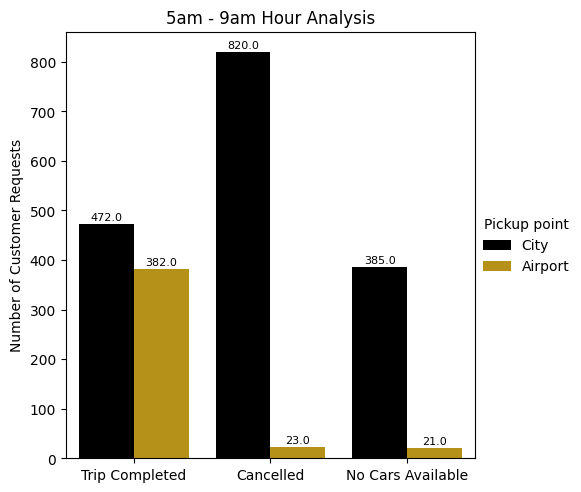

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom palette
custom_palette = [(0, 0, 0), (208/255, 158/255, 0/255)]

# Filter data for morning peak hour
morning_peak_hour_data = uber_data[uber_data['Time slot'] == '5am - 9am']

# Plot bar chart
morning_peak_hour_analysis = sns.catplot(data=morning_peak_hour_data,
                                         x='Status',
                                         hue='Pickup point',
                                         kind='count',
                                         palette=custom_palette)

# Set y-axis labels
for ax in morning_peak_hour_analysis.axes.flat:
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Set plot title and labels
morning_peak_hour_analysis.set(title='5am - 9am Hour Analysis',
                               ylabel='Number of Customer Requests',
                               xlabel='')

# Add a black border around the plot
sns.despine(ax=ax, left=True, bottom=True,right=True, top=True)
for spine in ['top', 'right','left','bottom']:
    ax.spines[spine].set_visible(True)

# Show plot
plt.show()


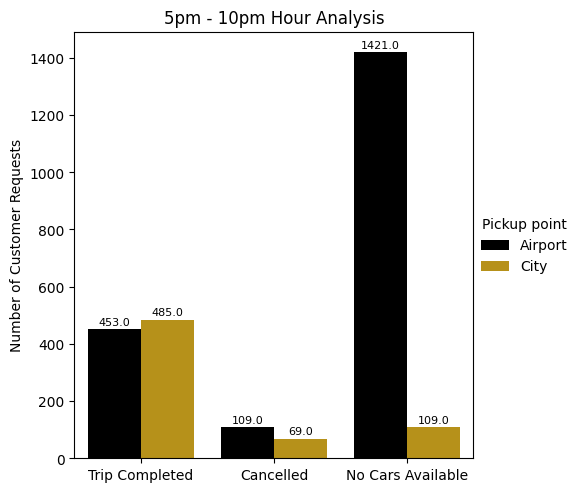

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom palette
custom_palette = [(0, 0, 0), (208/255, 158/255, 0/255)]

# Filter data for morning peak hour
morning_peak_hour_data = uber_data[uber_data['Time slot'] == '5pm - 10pm']

# Plot bar chart
morning_peak_hour_analysis = sns.catplot(data=morning_peak_hour_data,
                                         x='Status',
                                         hue='Pickup point',
                                         kind='count',
                                         palette=custom_palette)

# Set y-axis labels
for ax in morning_peak_hour_analysis.axes.flat:
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Set plot title and labels
morning_peak_hour_analysis.set(title='5pm - 10pm Hour Analysis',
                               ylabel='Number of Customer Requests',
                               xlabel='')

# Add a black border around the plot
sns.despine(ax=ax, left=True, bottom=True,right=True, top=True)
for spine in ['top', 'right','left','bottom']:
    ax.spines[spine].set_visible(True)

# Show plot
plt.show()
